# Import Statements



In [95]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import pylab
import scipy.stats as stats
import seaborn as sns

from io import StringIO
import sys

import pickle

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Data Preprocessing

In [96]:
# data Loading
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/nevada_weather.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [97]:
# dropping the year column
df.drop("Year",axis=1, inplace=True)

In [98]:
# mapping isDay (false/true) -> (0/1)
df.replace(to_replace=True, value=1, inplace=True)
df.replace(to_replace=False, value=0, inplace=True)

In [99]:
# dropping columns (refer preprocesssing notebook for details)
df = df.drop(["DHI", "Clearsky DHI", "Clearsky DNI", "Clearsky GHI", "DNI", "Fill Flag", "Dew Point"], axis = 1)

# Model Spilting

In [100]:
# Mapping: features (current time) -> GHI value (48 hours into the future)
total_records = len(df)
features = df[:total_records-288].drop('GHI', axis=1).reset_index()
output = df['GHI'][288:].reset_index()
df = pd.concat([features, output], join='inner', axis=1)
df.drop(['index'], axis=1, inplace=True)

In [101]:
# splitting the dataset into two: day and night
df_day = df[df.is_day == 1].drop('is_day', axis=1)
df_night = df[df.is_day == 0].drop('is_day', axis=1)

In [102]:
def feature_output_split(x):
  '''
  split the data into features (weather observations) and output (GHI) sets
  x: initial dataset
  returns: two datasets (feature & output)
  '''
  
  total_records = len(x)
  features = x.drop('GHI', axis=1)
  output = x['GHI']

  return features, output

In [103]:
# feature-output split for the whole data (df), day data (df_day) & night data (df_night)
feature_df, GHI = feature_output_split(df)
day_feature_df, day_GHI = feature_output_split(df_day)
night_feature_df, night_GHI = feature_output_split(df_night)

In [104]:
# train-test split for the whole data (df), day data (df_day) & night data (df_night)
x_train, x_test, y_train, y_test = train_test_split(feature_df, GHI, test_size=.20, random_state=42)
day_x_train, day_x_test, day_y_train, day_y_test = train_test_split(day_feature_df, day_GHI, test_size=.20, random_state=42)
night_x_train, night_x_test, night_y_train, night_y_test = train_test_split(night_feature_df, night_GHI, test_size=.20, random_state=42)

# Feature Expansion

In [105]:
def apply_LR(x_train, y_train, x_test, y_test, filename):
  '''
  applies LR on the train data (x_train, y_train),
  and uses the same to print the train and test RMSE
  
  it also saves the model in pickel file ('filename')
  '''

  linear = LinearRegression()
  linear.fit(x_train, y_train)

  # save the model to disk
  pickle.dump(linear, open("../Weights/" + filename, 'wb'))

  y_train_pred = linear.predict(x_train)
  train_rmse = metrics.mean_squared_error(y_train, y_train_pred) ** 0.5
  print("Train RMSE: ", train_rmse)
  y_test_pred = linear.predict(x_test)
  test_rmse = metrics.mean_squared_error(y_test, y_test_pred) ** 0.5
  print("Test RMSE: ", test_rmse)

In [106]:
def combine_result(y1, y1_pred, y2, y2_pred):
  '''
  combine both models predictions to return the final RMSE
  '''
  combined_y_pred = np.concatenate([y1_pred, y2_pred])
  combined_y = np.concatenate([y1, y2])
  rmse = metrics.mean_squared_error(combined_y, combined_y_pred) ** 0.5
  return rmse

In [107]:
def expand_features15(df, n):
  '''
  expand features on the whole data (15 features) (with is_day column)
  returns dataset with 15*(n+1) features
  '''

  list_df=[]
  numpy_df=df.to_numpy()
  final_df=numpy_df

  for i in range(n):
    list_df.append(df.to_numpy())
    list_df[i][i+1:len(numpy_df),:]=numpy_df[:len(numpy_df)-(i+1),:]
    final_df=np.concatenate((final_df,list_df[i]),axis=1)
  
  list_names=["Month",	"Day"	,"Hour",	"Minute",	"Temperature",	"Cloud Type",	"Dew Point",	"Relative Humidity",	"Solar Zenith Angle",	"Surface Albedo",	"Pressure",	"Precipitable Water",	"Wind Direction",	"Wind Speed", "is_day"]
  for i in range(n):
    for j in range(15):
      list_names.append(list_names[j]+str(i))
  

  expanded_df = pd.DataFrame(final_df, columns = list_names)
  return expanded_df,list_names

In [108]:
def feature_expansion15_withoutPCA(feature_df,GHI,n, filename):
  '''
  expand features on the whole data (15 features) (with is_day column)
  then applies LR on the expanded features to print the train-test RMSE 
  '''

  expanded_df, expanded_features_without=expand_features15(feature_df,n)
  print(expanded_df.shape)

  expanded_x_train, expanded_x_test, expanded_y_train, expanded_y_test = train_test_split(expanded_df, GHI, test_size=.20, random_state=42)

  print("Whole Dataset Model")
  apply_LR(expanded_x_train, expanded_y_train, expanded_x_test, expanded_y_test, filename)

In [109]:
def expand_features(df, n):
  '''
  expand features on the day-night data (14 features) (without is_day column)
  returns dataset with 15*(n+1) features
  '''

  list_df=[]
  numpy_df=df.to_numpy()
  final_df=numpy_df

  for i in range(n):
    list_df.append(df.to_numpy())
    list_df[i][i+1:len(numpy_df),:]=numpy_df[:len(numpy_df)-(i+1),:]
    final_df=np.concatenate((final_df,list_df[i]),axis=1)
  
  list_names=["Month",	"Day"	,"Hour",	"Minute",	"Temperature",	"Cloud Type",	"Dew Point",	"Relative Humidity",	"Solar Zenith Angle",	"Surface Albedo",	"Pressure",	"Precipitable Water",	"Wind Direction",	"Wind Speed"]
  for i in range(n):
    for j in range(14):
      list_names.append(list_names[j]+str(i))
  

  expanded_df = pd.DataFrame(final_df, columns = list_names)
  return expanded_df,list_names

In [110]:
def feature_expansion_withoutPCA(day_feature_df,night_feature_df,day_GHI,night_GHI,n, filename):
  '''
  expand features on the day/night data (14 features) (without is_day column)
  then applies LR on the expanded features to print the train-test RMSE 
  '''
  expanded_day_df, expanded_features_without=expand_features(day_feature_df,n)
  expanded_night_df, expanded_features_without=expand_features(night_feature_df,n)
  print(expanded_day_df.shape)

  expanded_day_x_train, expanded_day_x_test, expanded_day_y_train, expanded_day_y_test = train_test_split(expanded_day_df, day_GHI, test_size=.20, random_state=42)
  expanded_night_x_train, expanded_night_x_test, expanded_night_y_train, expanded_night_y_test = train_test_split(expanded_night_df, night_GHI, test_size=.20, random_state=42)

  print("Day Time Model")
  apply_LR(expanded_day_x_train, expanded_day_y_train, expanded_day_x_test, expanded_day_y_test, filename + 'day' + str(n) + '.pkl')

  print("Night Time Model")
  apply_LR(expanded_night_x_train, expanded_night_y_train, expanded_night_x_test, expanded_night_y_test, filename + 'night' + str(n) + '.pkl')


  print("Combined Model")
  day_linear = LinearRegression()
  day_linear.fit(expanded_day_x_train, expanded_day_y_train)
  night_linear = LinearRegression()
  night_linear.fit(expanded_night_x_train, expanded_night_y_train)

  day_y_train_pred = day_linear.predict(expanded_day_x_train)
  night_y_train_pred = night_linear.predict(expanded_night_x_train)
  train_rmse = combine_result(expanded_day_y_train, day_y_train_pred, expanded_night_y_train, night_y_train_pred)
  print("Train RMSE: ", train_rmse)

  day_y_test_pred = day_linear.predict(expanded_day_x_test)
  night_y_test_pred = night_linear.predict(expanded_night_x_test)
  test_rmse = combine_result(expanded_day_y_test, day_y_test_pred, expanded_night_y_test, night_y_test_pred)
  print("Test RMSE: ", test_rmse)

## Single Model (Without PCA)

In [111]:
list_n=[1,5,25,40,100]

for i in list_n:
  print(i)
  feature_expansion15_withoutPCA(feature_df,GHI,i, 'FeatureExpansion/withoutPCA_'+ str(i) + '.pkl')

1
(52272, 30)
Whole Dataset Model
Train RMSE:  145.75308716497506
Test RMSE:  147.68721941279728
5
(52272, 90)
Whole Dataset Model
Train RMSE:  134.92882235811217
Test RMSE:  137.54002269057318
25
(52272, 390)
Whole Dataset Model
Train RMSE:  107.35595686467299
Test RMSE:  112.92460085017986
40
(52272, 615)
Whole Dataset Model
Train RMSE:  98.46231086420478
Test RMSE:  122.58349846030963
100
(52272, 1515)
Whole Dataset Model
Train RMSE:  84.31045569096428
Test RMSE:  272.58763371468973


## Day Night Model (Without PCA)

In [112]:
list_n=[1,5,25,40,100]

for i in list_n:
  print(i)
  feature_expansion_withoutPCA(day_feature_df,night_feature_df,day_GHI,night_GHI,i, 'FeatureExpansion/withoutPCA_')

1
(26674, 28)
Day Time Model
Train RMSE:  113.1911480707158
Test RMSE:  114.93920406393704
Night Time Model
Train RMSE:  6.121855381358566
Test RMSE:  5.986153348395325
Combined Model
Train RMSE:  80.97142003607642
Test RMSE:  82.21250956938489
5
(26674, 84)
Day Time Model
Train RMSE:  112.63617962096625
Test RMSE:  114.65591097592491
Night Time Model
Train RMSE:  5.895410826116193
Test RMSE:  5.838491470397497
Combined Model
Train RMSE:  80.56726699087397
Test RMSE:  82.0051920552073
25
(26674, 364)
Day Time Model
Train RMSE:  110.19316691873894
Test RMSE:  112.8936720305462
Night Time Model
Train RMSE:  5.721125653182273
Test RMSE:  5.707383903794805
Combined Model
Train RMSE:  78.81815358567825
Test RMSE:  80.74335100166348
40
(26674, 574)
Day Time Model
Train RMSE:  107.89956042222654
Test RMSE:  112.24511604738959
Night Time Model
Train RMSE:  5.462784421001034
Test RMSE:  5.515306962494638
Combined Model
Train RMSE:  77.17271096021504
Test RMSE:  80.27405670811244
100
(26674, 141

## Single Model (with PCA)

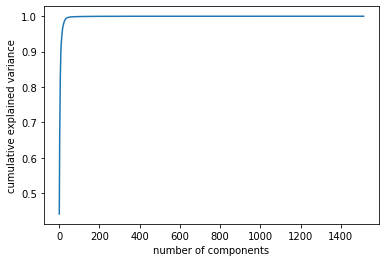

In [113]:
# PCA plot
expanded_df, expanded_features_without=expand_features15(feature_df,100)

pca = PCA().fit(expanded_df)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [114]:
num_features = 250

pca = PCA(n_components=num_features)
pca_feature_df = pca.fit_transform(expanded_df)
print('\n Total Variance Explained:', round(sum(list(pca.explained_variance_ratio_))*100, 2))

list_names_pca=[]
for i in range(num_features):
  list_names_pca.append("pca_component"+str(i+1))


 Total Variance Explained: 99.98


In [115]:
pca_feature_dataframe=pd.DataFrame(pca_feature_df, columns=list_names_pca)
expanded_x_train, expanded_x_test, expanded_y_train, expanded_y_test = train_test_split(pca_feature_dataframe, GHI, test_size=.20, random_state=42)

print("Whole Dataset Model")
apply_LR(expanded_x_train, expanded_y_train, expanded_x_test, expanded_y_test, 'FeatureExpansion/withPCA_whole_'+'100exp' +'250comp.pkl')

Whole Dataset Model
Train RMSE:  97.96414685808345
Test RMSE:  99.35370471310807


## Day Night Model (with PCA)

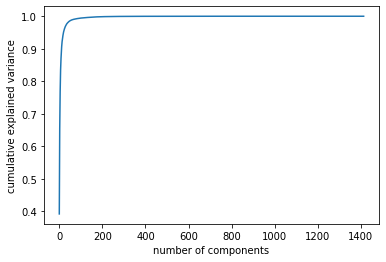

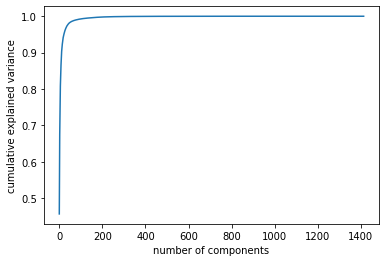

In [116]:
# day and night PCA plots
expanded_day_df, expanded_features_without=expand_features(day_feature_df,100)
expanded_night_df, expanded_features_without=expand_features(night_feature_df,100)

day_pca = PCA().fit(expanded_day_df)
plt.plot(np.cumsum(day_pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

night_pca = PCA().fit(expanded_night_df)
plt.plot(np.cumsum(night_pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [117]:
num_features = 250

day_num_features=num_features

day_pca = PCA(n_components=day_num_features)
day_pca_feature_df = day_pca.fit_transform(expanded_day_df)
print('\n Total Variance Explained:', round(sum(list(day_pca.explained_variance_ratio_))*100, 2))

night_num_features=num_features
night_pca = PCA(n_components=night_num_features)
night_pca_feature_df = night_pca.fit_transform(expanded_night_df)
print('\n Total Variance Explained:', round(sum(list(night_pca.explained_variance_ratio_))*100, 2))

list_names_pca=[]
for i in range(num_features):
  list_names_pca.append("pca_component"+str(i+1))


 Total Variance Explained: 99.92

 Total Variance Explained: 99.88


In [118]:
day_pca_feature_dataframe=pd.DataFrame(day_pca_feature_df,columns=list_names_pca)

night_pca_feature_dataframe=pd.DataFrame(night_pca_feature_df,columns=list_names_pca)

expanded_day_x_train, expanded_day_x_test, expanded_day_y_train, expanded_day_y_test = train_test_split(day_pca_feature_dataframe, day_GHI, test_size=.20, random_state=42)
expanded_night_x_train, expanded_night_x_test, expanded_night_y_train, expanded_night_y_test = train_test_split(night_pca_feature_dataframe, night_GHI, test_size=.20, random_state=42)

apply_LR(expanded_day_x_train, expanded_day_y_train, expanded_day_x_test, expanded_day_y_test, 'FeatureExpansion/withPCA_day_'+'100exp' +'250comp.pkl')
apply_LR(expanded_night_x_train, expanded_night_y_train, expanded_night_x_test, expanded_night_y_test, 'FeatureExpansion/withPCA_night_'+'100exp' +'250comp.pkl')

Train RMSE:  109.15673762522295
Test RMSE:  111.6216180045608
Train RMSE:  5.66526388762073
Test RMSE:  5.600362258883293


In [119]:
print("Combined Model")
day_linear = LinearRegression()
day_linear.fit(expanded_day_x_train, expanded_day_y_train)
night_linear = LinearRegression()
night_linear.fit(expanded_night_x_train, expanded_night_y_train)

# Train RMSE
day_y_train_pred = day_linear.predict(expanded_day_x_train)
night_y_train_pred = night_linear.predict(expanded_night_x_train)
train_rmse = combine_result(expanded_day_y_train, day_y_train_pred, expanded_night_y_train, night_y_train_pred)
print("Train RMSE: ", train_rmse)

# Test RMSE
day_y_test_pred = day_linear.predict(expanded_day_x_test)
night_y_test_pred = night_linear.predict(expanded_night_x_test)
test_rmse = combine_result(expanded_day_y_test, day_y_test_pred, expanded_night_y_test, night_y_test_pred)
print("Test RMSE: ", test_rmse)

Combined Model
Train RMSE:  78.07675120141843
Test RMSE:  79.83208476661937
